<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/RegressionModelv20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import arviz as az

import pymc as pm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [2]:
n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
print(X)
β_true = np.logspace(0, 1, 2,base=2)
σ_true = 1
print(β_true)
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)

[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


(array([1., 2.]),
 array([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]]),
 array([-1.26485598,  3.18428092,  0.35504683,  1.70205735, -0.53348411,
         3.43950814,  1.54291277,  3.0241124 ,  0.07233906,  2.68438127]))

Bias Against

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_beta = pm.MvNormal(f'prior_beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))
    mean_beta = pm.Deterministic('mean_beta', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, y_)) + np.dot(Sigma_beta_inv, beta0)))

    # Posterior distribution for beta at each point
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_beta, cov=cov_beta_post, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-0.9674332  -4.56339403 -0.4767753  -0.6064445   1.01165902  0.01295937
  0.0905542  -2.952668   -2.42100643 -0.43504974]


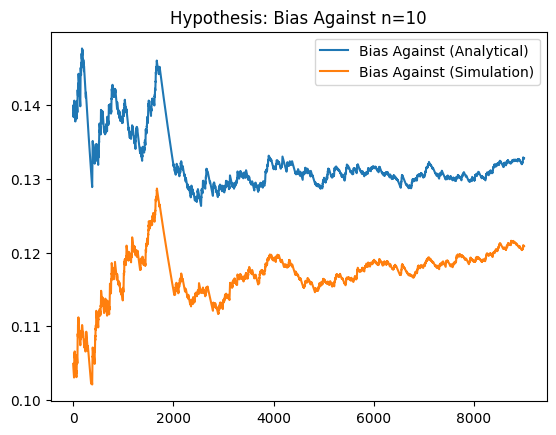

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

Lower and Upper

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pdl)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 1.18864419  1.97617225  5.13989887  1.04093233  0.72568334 -0.47266071
 -2.03198277 -1.78806747 -0.25091583 -0.95616747]


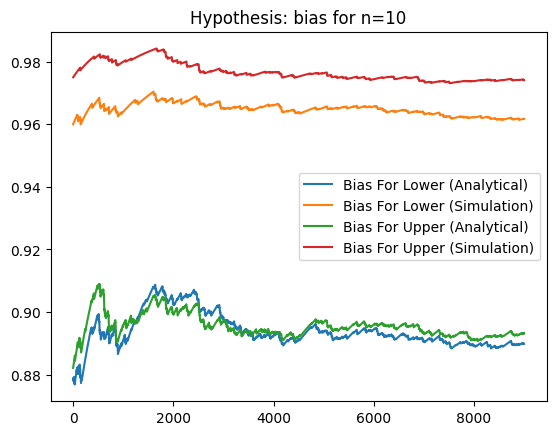

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-0.0723552   0.58540482 -2.39904436 -5.20827362  2.29459096 -1.91137732
  1.46851988  1.37698385  2.34637142  2.37426635]


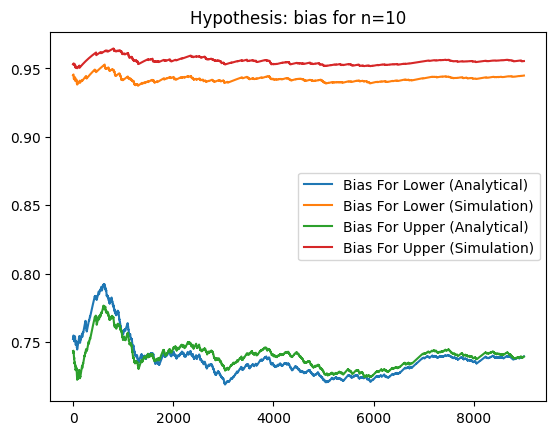

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 3.03560901 -2.07038783  0.61814144  0.66794863  2.97286942 -2.76232196
  3.22461142  1.20497316 -1.67329648 -3.55428093]


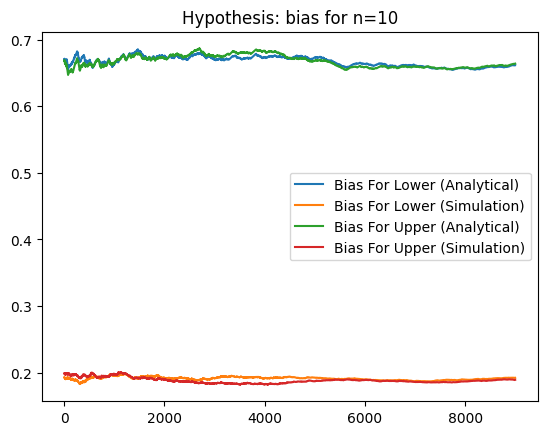

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-2.37820077  0.89242962 -4.21862477 -2.6013209   2.40332524  0.98295702
  2.09805358  5.95070841 -2.35597196  0.23675003]


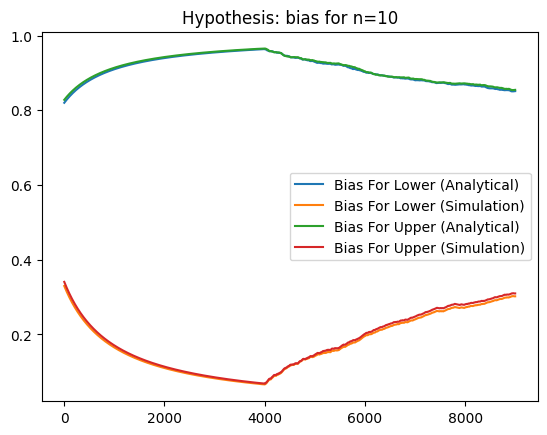

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) > 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) > 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 3.6005245   6.33766179  3.7063932  -1.0174652  -0.54964683 -0.04011638
 -4.75017577 -4.2789295  -0.79770088  2.88835665]


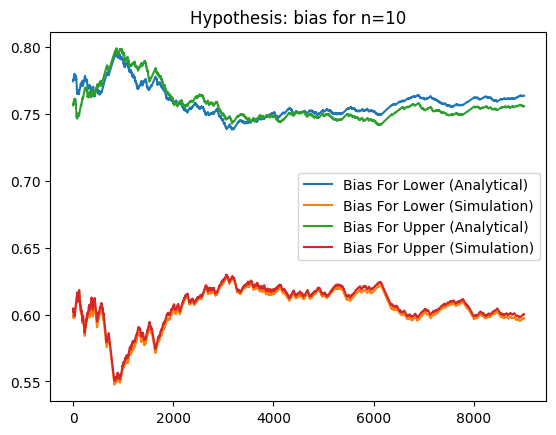

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) > 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) > 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


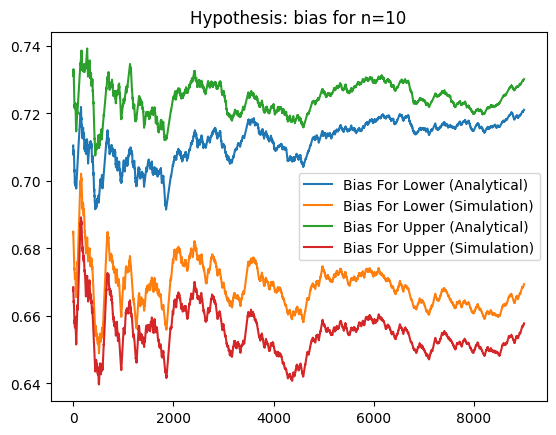

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) > 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) > 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(1.2-bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(1.2-bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-0.37908713  3.93013662  0.07636723  0.29205203  3.3780239   0.60589828
 -2.07279287 -0.72561117  0.53148428 -6.19877683]


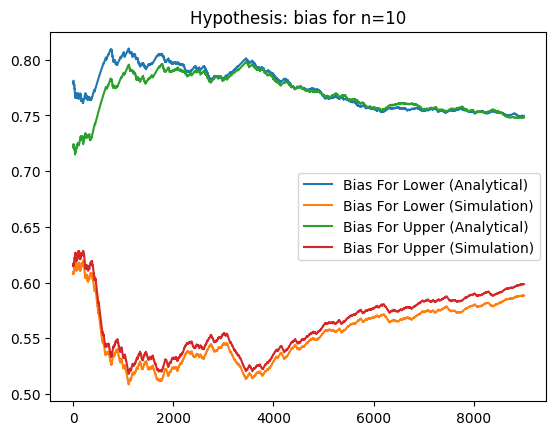

In [ ]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 0.71024353 -3.91784552  0.76248892 -0.85392158  1.22252823  4.18536053
 -6.17383029  0.2762201   3.93374436 -3.33396263]


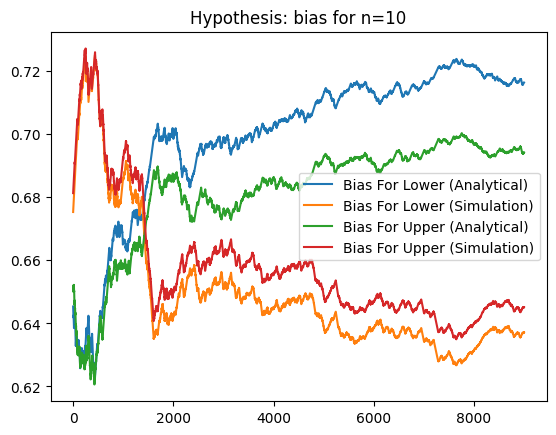

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 2.69037912 -2.91929504 -1.69742826  2.32754004  3.64157626 -1.5421185
  2.53032204  0.53315122  1.54052474  1.66493909]


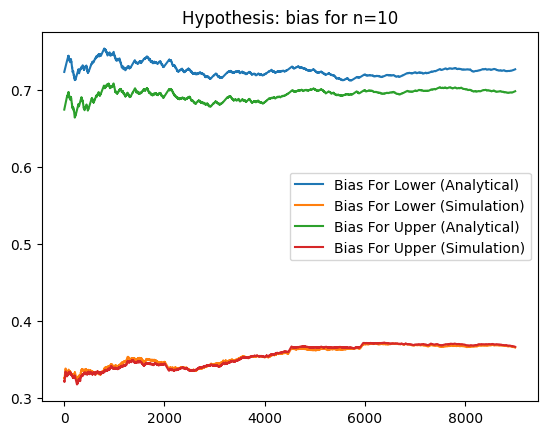

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
yl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
yu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(yl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(yu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) > 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) > 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + pm.math.dot(Sigma_beta_inv, beta-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-1.38344062  0.39830107  0.28923865 -2.022256   -6.60928797  0.61126111
 -5.64399171  1.16899472 -1.8631171   0.94913613]


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 1.44402718  0.6040097  -2.47359625 -3.18155721  1.40631206 -0.06664364
 -0.88375286 -0.73494603 -4.28952645  3.20361412]


In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [-3.03657137  5.36666187 -3.48939898 -2.14476087  3.38206346 -0.77689167
  2.24341808  0.86596846  0.8682082  -4.43729171]


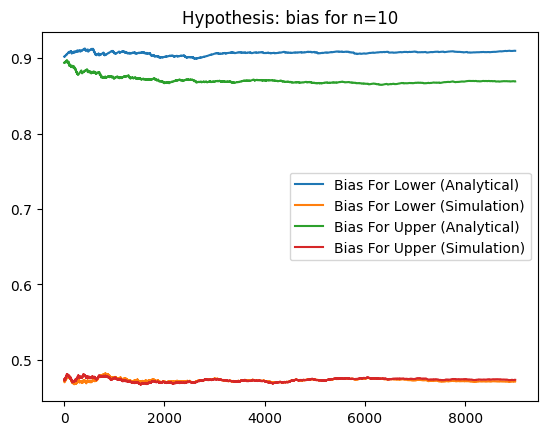

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [-2.11336776  2.08761568 -2.23581662 -3.13810527 -0.85789634  0.52699026
 -1.79716058 -0.80446915 -1.0103443   0.02198021]


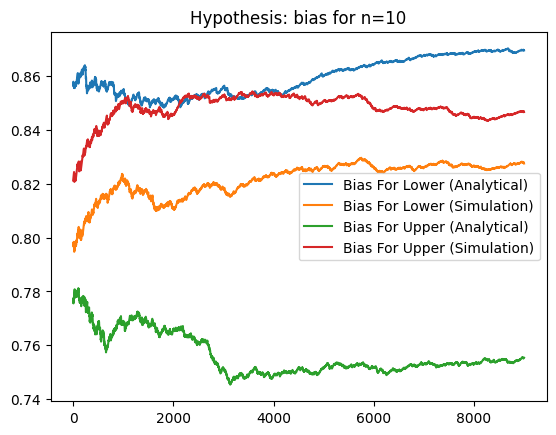

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + pm.math.dot(Sigma_beta_inv, beta-delta)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + pm.math.dot(Sigma_beta_inv, beta+delta)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-3.54037726  0.97129627 -4.39932742 -2.13780297 -2.48250644 -1.05767143
  0.42986324  1.84421876 -2.86744459 -2.17803064]


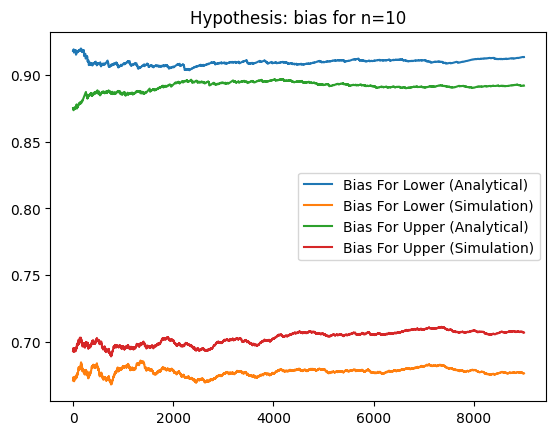

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Shapes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from matplotlib import cm

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta0 = 0.1  # Half-diagonal length of the rhombus
delta1 = 0.25

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta0, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta1],  # Top vertex
    [beta0[0] - delta0, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta1]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 2
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)

num_points = len(curved_rhombus_points)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')
num_points = len(curved_rhombus_points)

for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu_lower = pm.Deterministic("mu_lower", pm.math.dot(X, beta +delta))
    mu_upper = pm.Deterministic("mu_upper", pm.math.dot(X, beta -delta))

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta0)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pdl)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 10  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_pd = pm.Deterministic(f'prior_pd_{i}', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))



        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 298.39 seconds


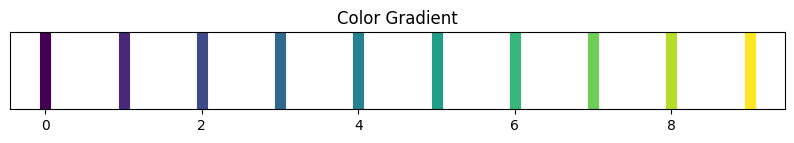

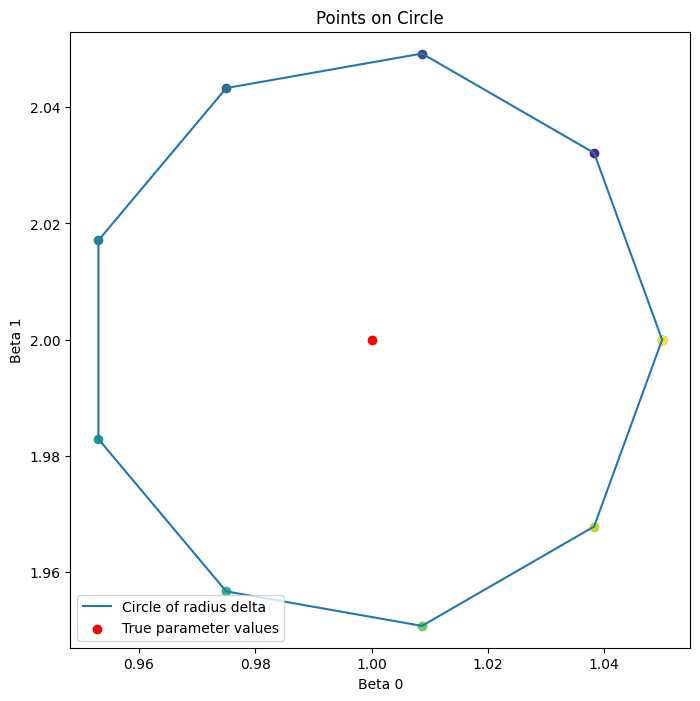

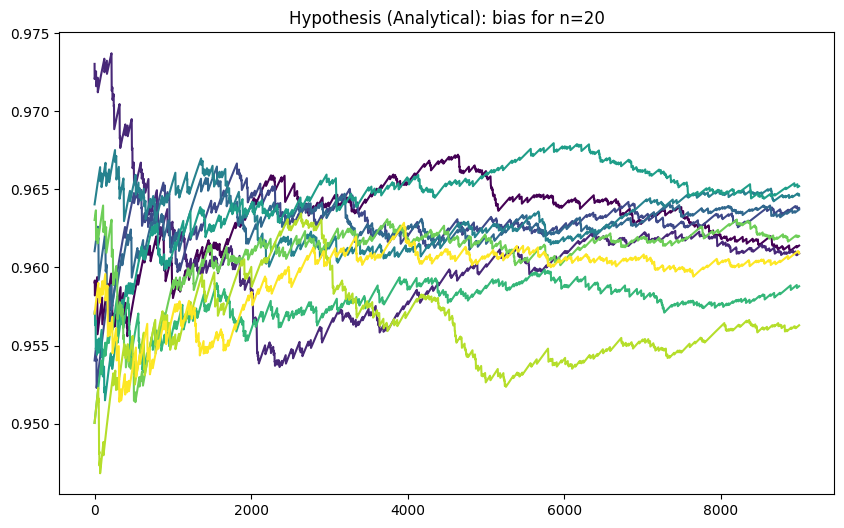

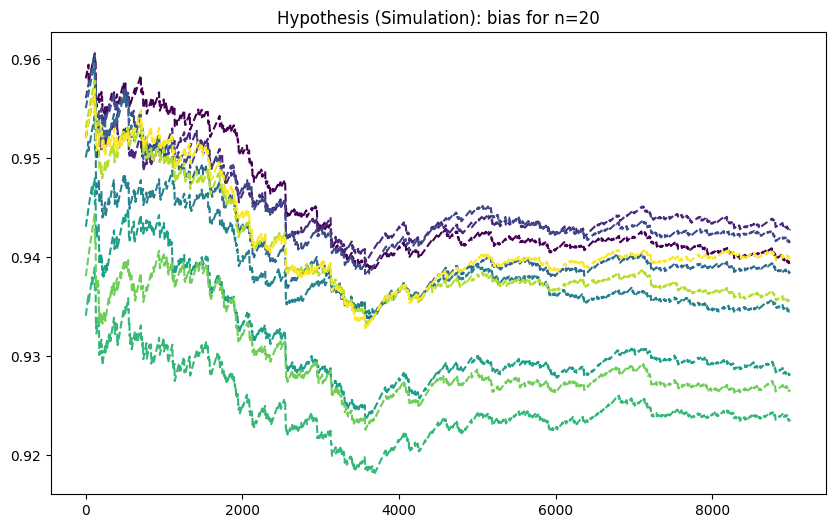

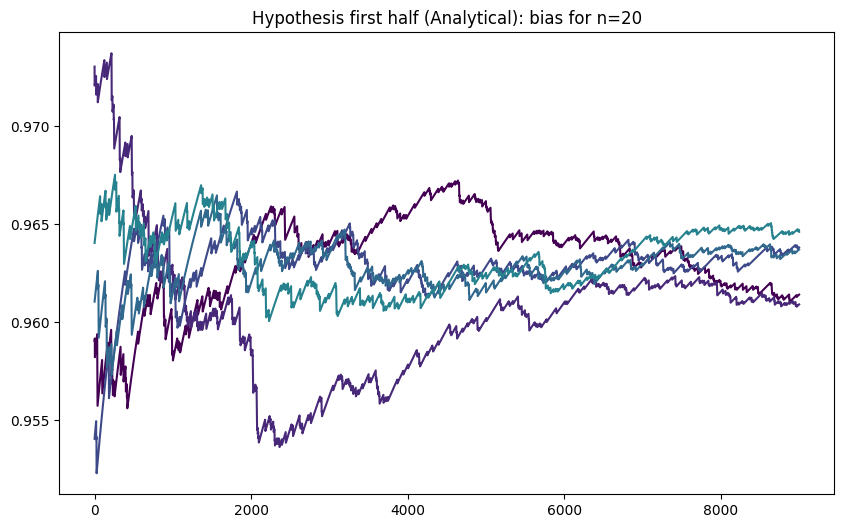

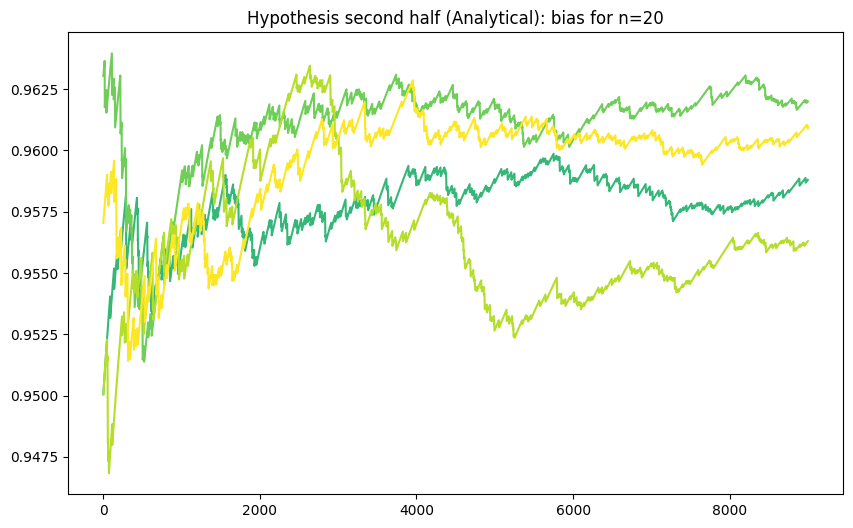

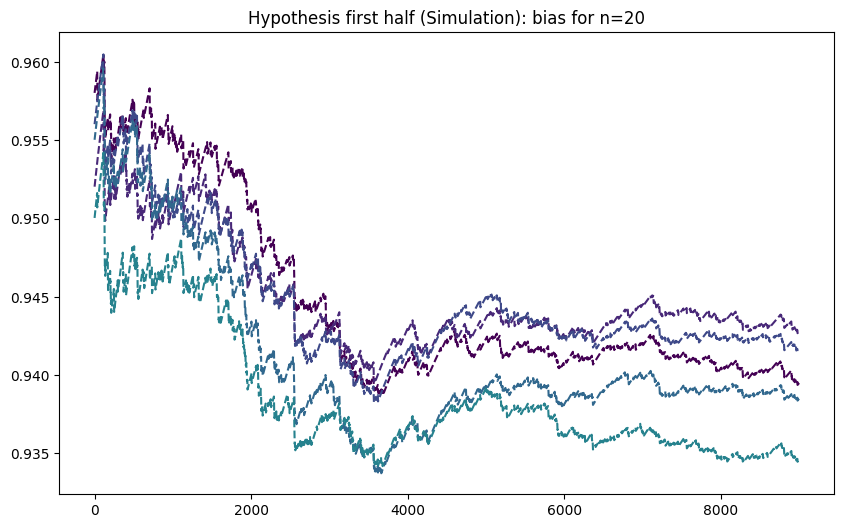

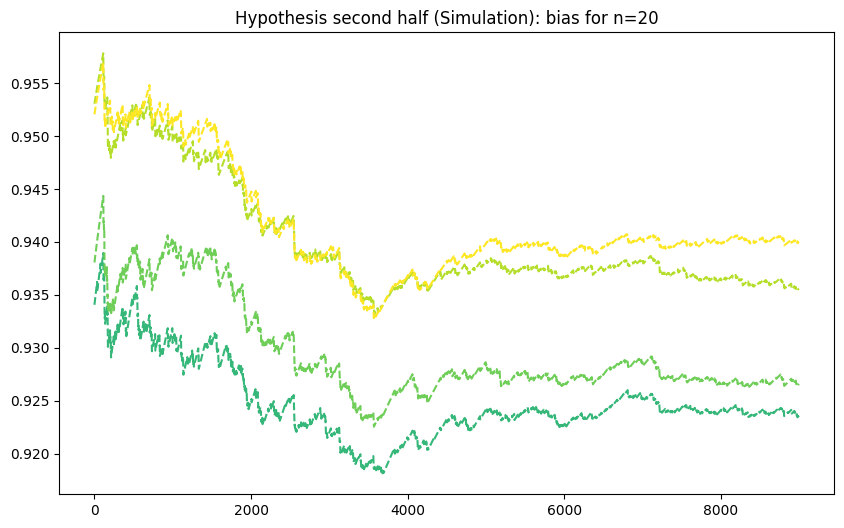

In [ ]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

Uneven rhombus

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta0 = 0.05  # Half-diagonal length of the rhombus
delta1 = 0.15
# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta0, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta1],  # Top vertex
    [beta0[0] - delta0, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta1]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top

# Generate points on the inward-curving rhombus
num_points_per_curve = 4
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov = (mu_prior_sigma**2) * np.eye(p), shape=p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma0**2) * np.eye(n), shape=n)

        # Prior for beta at each point
        prior_pd = pm.Deterministic(f'prior_pd_{i}', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, betal)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


Cell execution time: 531.26 seconds


[2.41914942 1.69191126 1.76645059 ... 2.86689796 2.89540991 1.54587022]
[-1.83787707 -1.83787707 -1.83787707 ... -1.83787707 -1.83787707
 -1.83787707]
[ 0.58127236 -0.1459658  -0.07142648 ...  1.02902089  1.05753285
 -0.29200685]


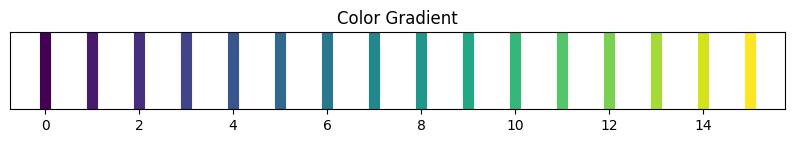

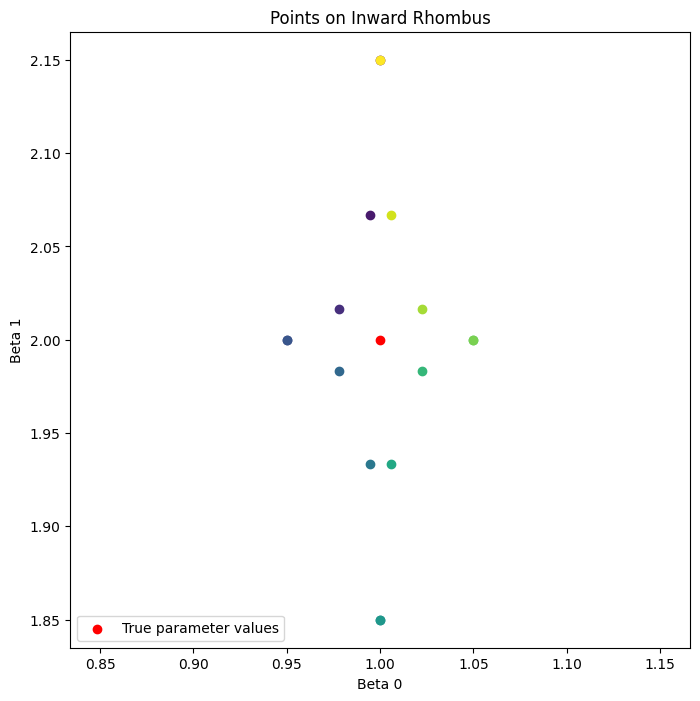

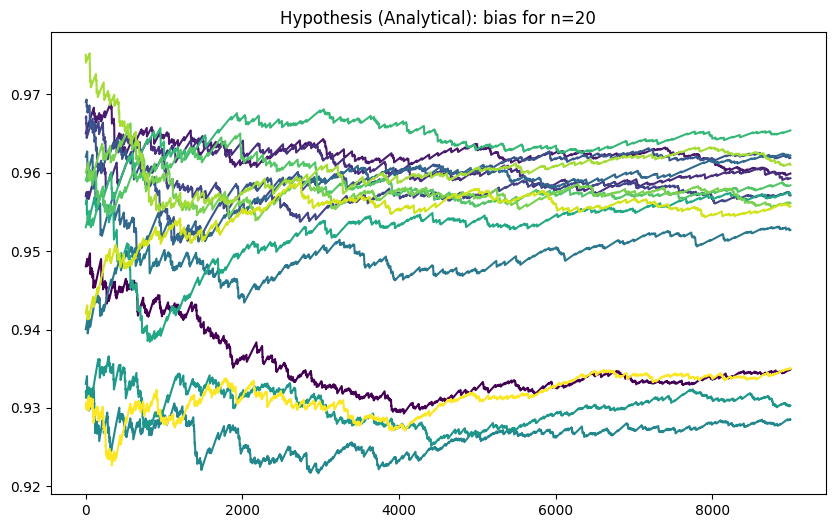

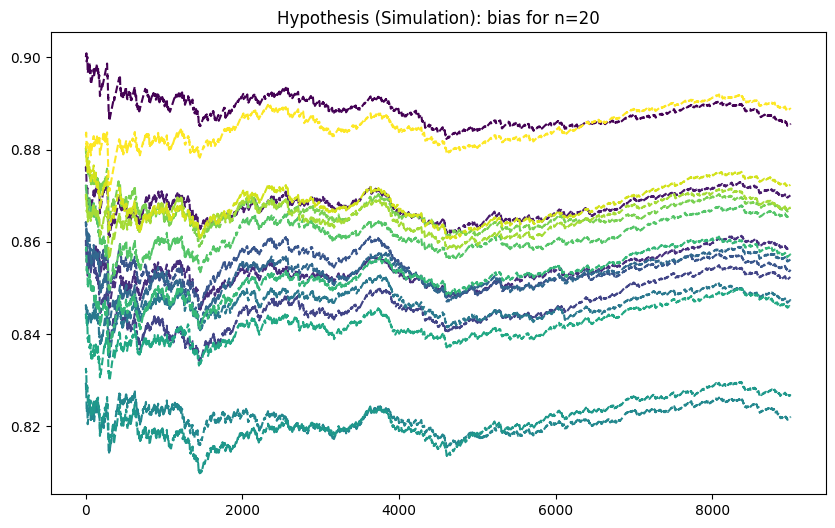

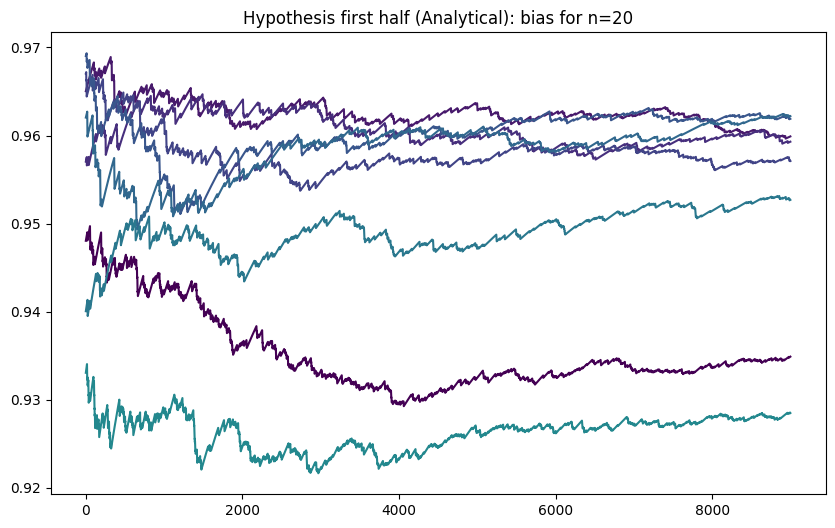

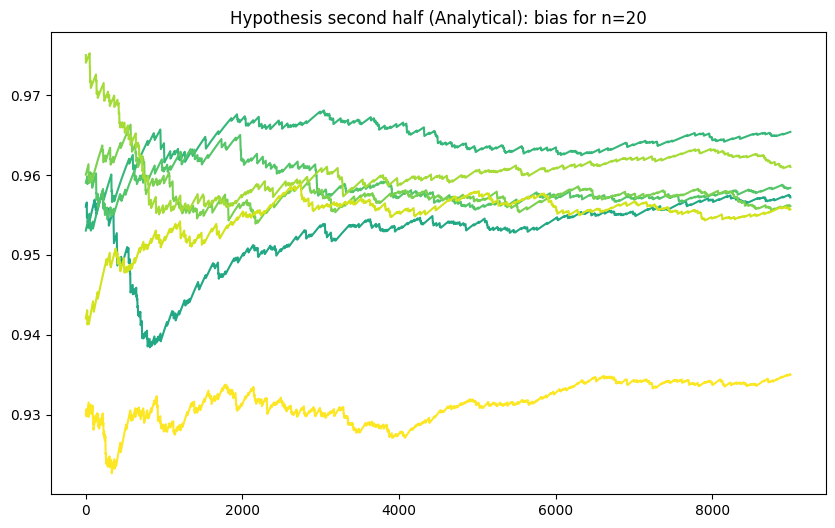

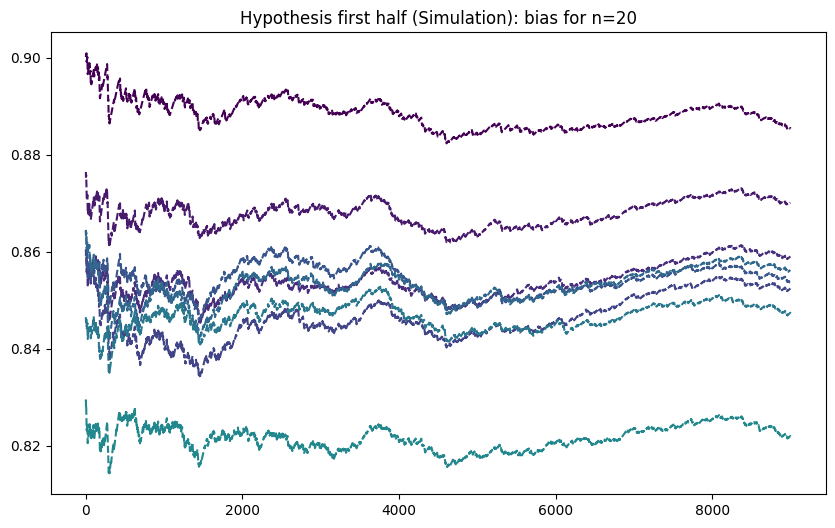

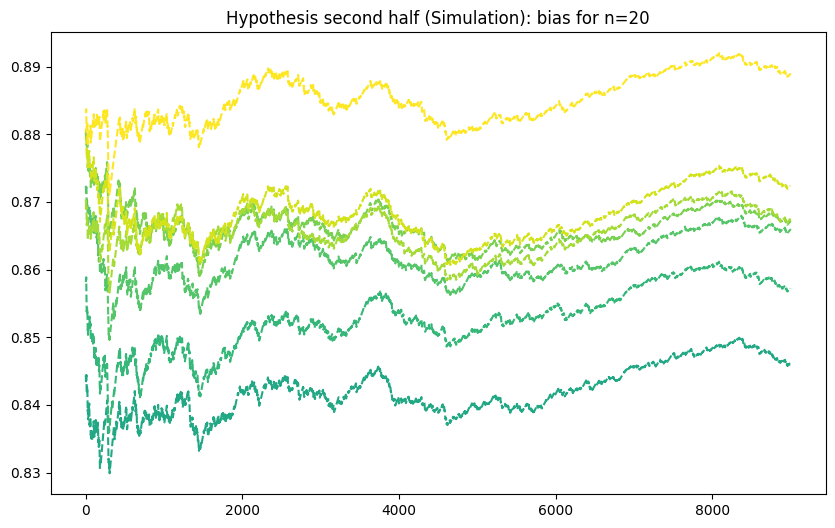

In [ ]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)




# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    if idx == 0:
        print(idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel())
        print(idata.posterior[f'prior_pd_{idx}'].values.ravel())
        print(idata.posterior[f'posterior_pdl_{idx}'].values.ravel())

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta0)))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    Sigma_beta_inv = beta_upper*(np.eye(p) / mu_prior_sigma**2)
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 1.65349637e-01 -1.86162251e-03 -1.60630751e-01 -3.02288870e+00
 -1.43576353e+00  1.63966547e+00 -2.72505384e+00 -7.03077147e-01
 -3.44335089e+00 -2.00040280e+00]


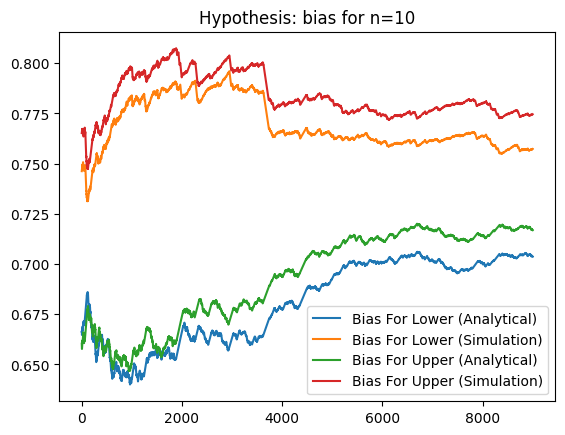

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)))

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_))))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    Sigma_beta_inv = (np.eye(p) / mu_prior_sigma**2)
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)))
    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_))))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [-2.79914577 -1.67042598  2.03152617  3.08848113  0.89996824  0.48630994
  3.97279096 -2.33003862 -1.6057783  -3.20773137]


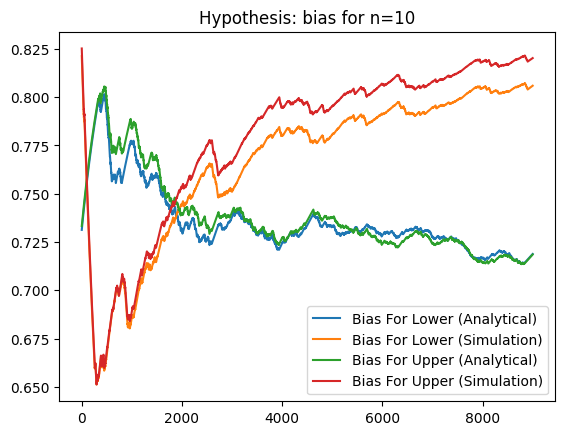

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)))

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_))))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    Sigma_beta_inv = (np.eye(p) / mu_prior_sigma**2)
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)))
    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_))))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 1.40680287  2.29944004  0.94176175  2.84487076  2.94169856  1.74760602
  1.96183048  0.87734568 -0.63919027  1.13647186]


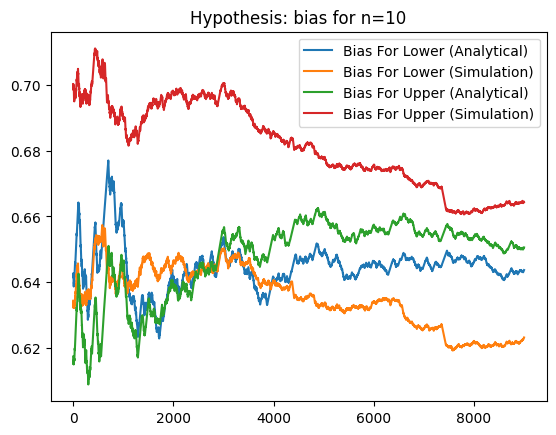

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [2]:
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math
from matplotlib import cm


def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [ ]:
n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
print(X)
β_true = np.logspace(0, 1, 2,base=2)
σ_true = 1
print(β_true)
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)

[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


(array([1., 2.]),
 array([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]]),
 array([-1.26485598,  3.18428092,  0.35504683,  1.70205735, -0.53348411,
         3.43950814,  1.54291277,  3.0241124 ,  0.07233906,  2.68438127]))

In [3]:
n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
print(X)
β_true = np.logspace(1, 2, 2,base=2)
σ_true = 1
print(β_true)
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)

[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[2. 4.]


(array([2., 4.]),
 array([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]]),
 array([-1.26485598,  5.18428092,  0.35504683,  3.70205735, -0.53348411,
         6.43950814,  2.54291277,  6.0241124 ,  1.07233906,  5.68438127]))

In [ ]:
# Define prior parameters
β_prior_μ = β_true
β_prior_σ = 1
σ_prior_μ = 1
σ_prior_σ = 1
β_post_Φ = X.T@X + np.eye(p)*β_prior_σ**2
β_post_Σ = np.linalg.inv(β_post_Φ)
β_post_CholeskyLower = np.linalg.cholesky(β_post_Σ) # pt.linalg.cholesky # https://discourse.pymc.io/t/using-lkjcorr-together-with-mvnormal/13606/13?page=2
labels = ['slope_'+str(β_true[0]), 'slope_'+str(β_true[1])]

with pm.Model(coords={'coefs': labels}) as model:
    # Priors
    β = pm.MvNormal('β', mu=β_prior_μ, cov=(β_prior_σ**2)*np.eye(p), shape = p)
    σ2 = pm.InverseGamma("σ2", alpha=3, beta=2)
    #σ2 = pm.TruncatedNormal("σ2", mu=σ_prior_μ, sigma=σ_prior_σ, lower=0)


    # Likelihood
    mu = X@β
    y_ = pm.MvNormal('y_', mu=mu, cov=(σ2) * np.eye(n), shape=n)

    # Prior for beta at each point
    β_prior = pm.MvNormal.dist(mu=β_prior_μ, cov=(β_prior_σ**2) * np.eye(p), shape = p)
    β_prior_pdl = pm.Deterministic("β_prior_pdl", pm.logp(β_prior, β))

    #y_prior_pdl = pm.Deterministic("y_prior_lpd", pm.logp(y_prior, y_).sum())


    # Posterior distribution for beta at each point
    β_post_μ = β_post_Σ @ (X.T@y_ + β_prior_μ/β_prior_σ**2)
    β_post_pdl = pm.Deterministic('β_post_pdl', pm.logp(pm.MvNormal.dist(mu=β_post_μ, chol = β_post_CholeskyLower, shape=p), β))

    # Log BR
    logRB = pm.Deterministic("logRB", β_post_pdl - β_prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic('likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=σ_true * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



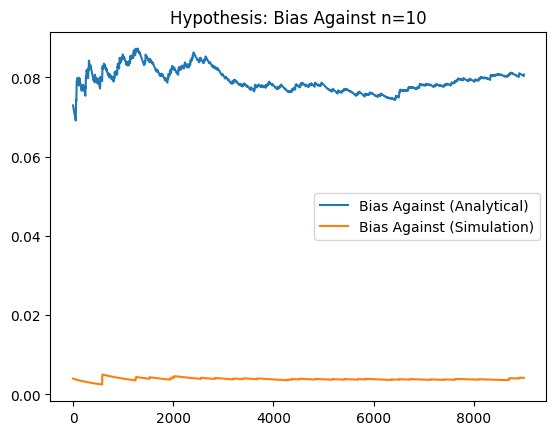

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['β'][:, :, 0].values.ravel()[:1000]
y_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.InverseGamma("sigma", alpha=3, beta=2)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))
    mean_beta = pm.Deterministic('mean_beta', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, y_)) + np.dot(Sigma_beta_inv, beta0)))
    β_post_CholeskyLower = np.linalg.cholesky(cov_beta_post)
    # Posterior distribution for beta at each point
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_beta, chol=β_post_CholeskyLower, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 0.88999456  3.22180479 -0.4260773   1.82786055  2.26994753  4.07848613
  2.12751769  1.48462331  0.60069966  1.40936359]


<ipython-input-6-30211727bcd2>:24: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


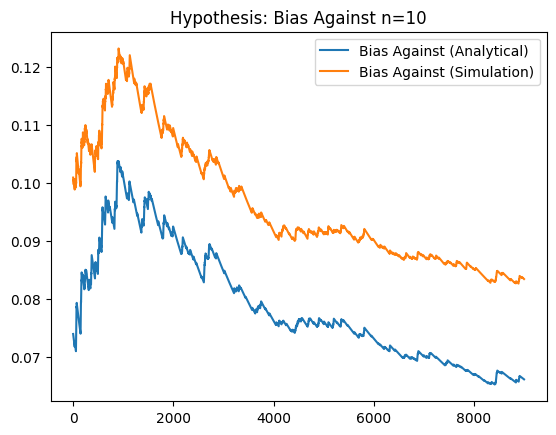

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)

print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, cov=cov_beta_post, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, cov=cov_beta_post, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



y [ 1.12080777 -2.38495193  2.23000334 -2.26326674  1.69882465 -1.06558077
 -0.65670119 -2.48976005 -1.75131531  1.83761145]


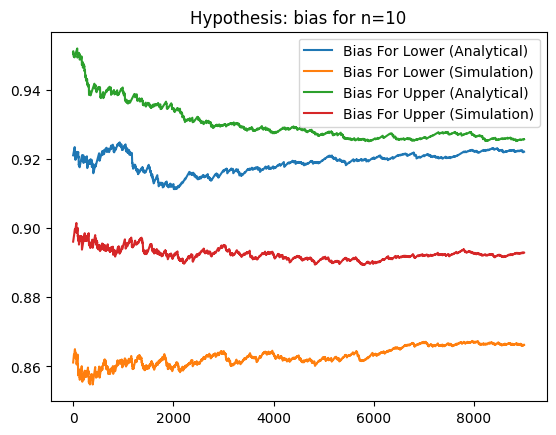

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]
# Generate response variable y

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)


with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p)
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta0))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yl_)) + np.dot(Sigma_beta_inv, beta_lower)))
    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    β_post_CholeskyLower = np.linalg.cholesky(cov_beta_post)

    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_CholeskyLower, shape=p), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, yu_)) + np.dot(Sigma_beta_inv, beta_upper)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_CholeskyLower, shape=p), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



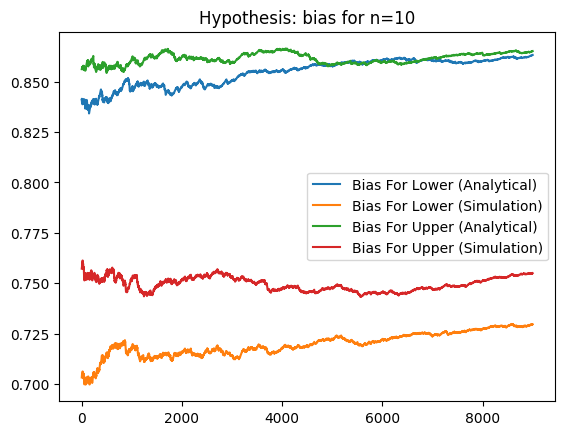

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-8-275779955501>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
<ipython-input-8-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


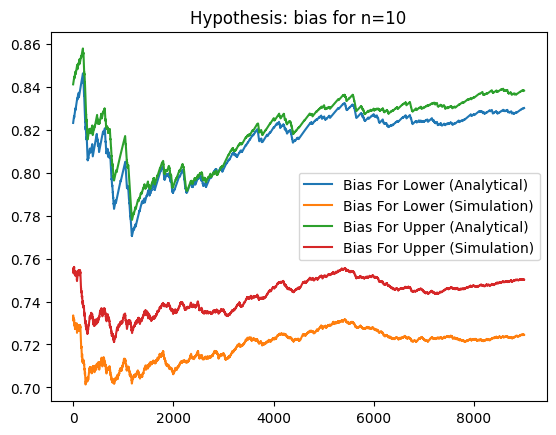

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(mu_prior_sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(mu_prior_sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-14-275779955501>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
<ipython-input-14-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


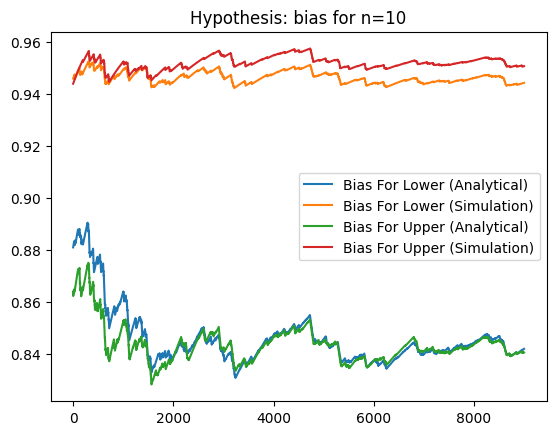

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(mu_prior_sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(mu_prior_sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-16-275779955501>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
<ipython-input-16-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


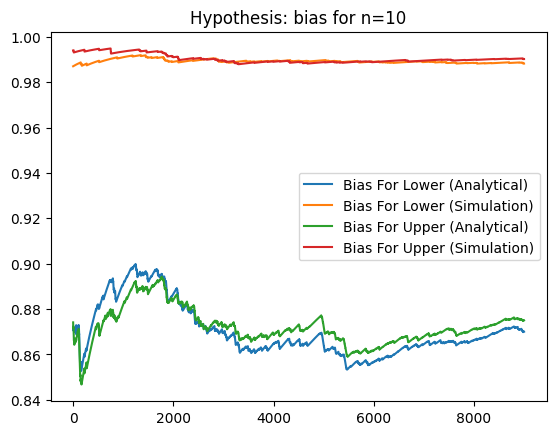

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(mu_prior_sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(mu_prior_sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-18-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


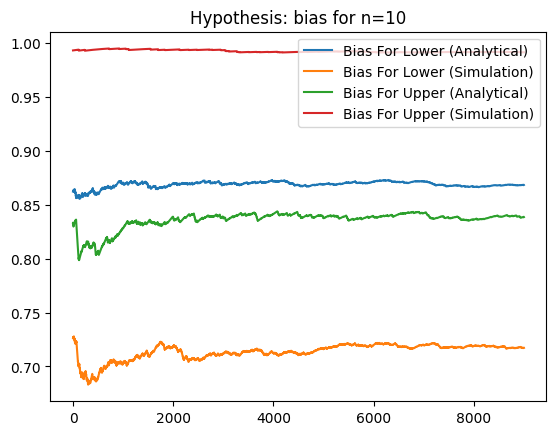

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(mu_prior_sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(mu_prior_sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-22-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


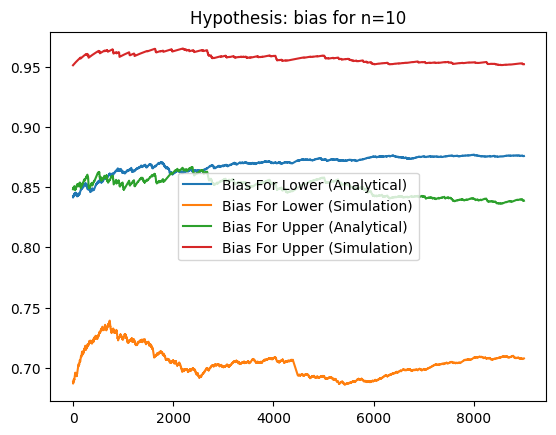

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = np.dot(X, beta_lower)
mu_upper = np.dot(X, beta_upper)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = pm.Deterministic('mu', pm.math.dot(X, beta))

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



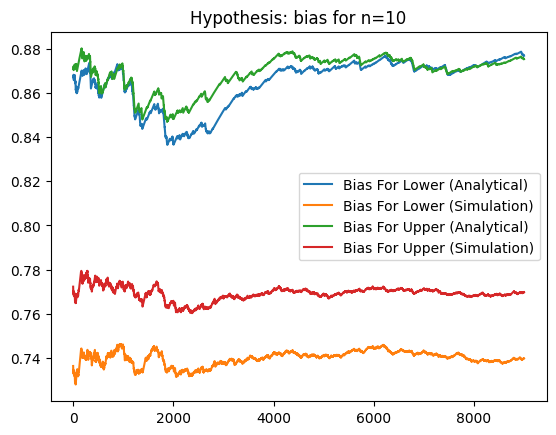

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-28-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


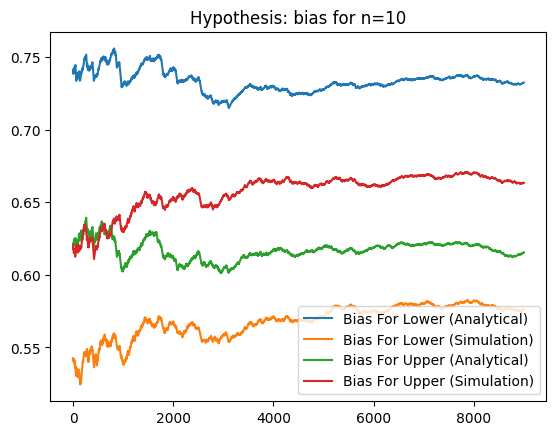

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-32-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


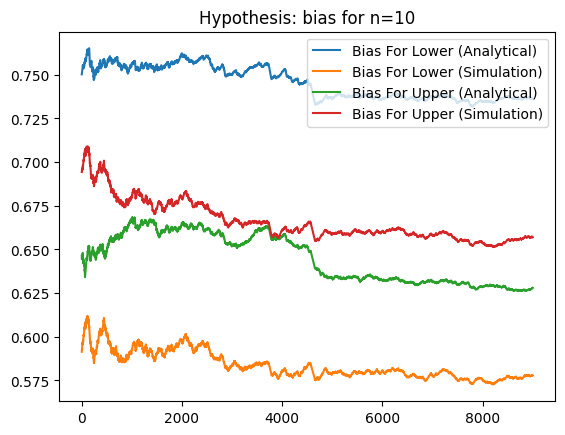

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



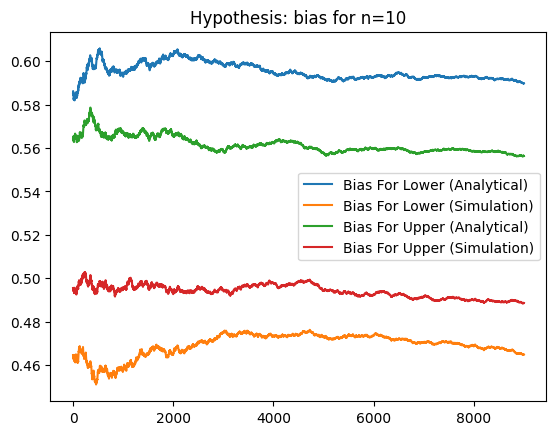

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta0/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



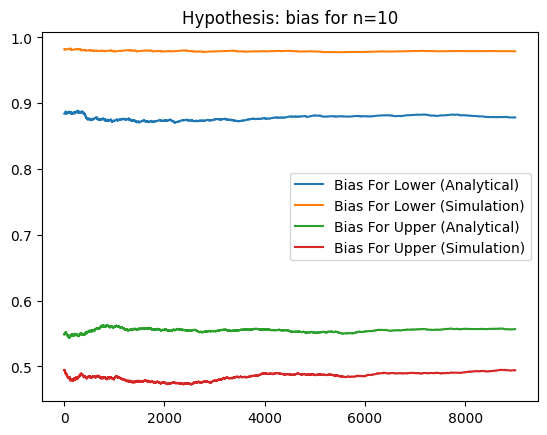

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta0/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



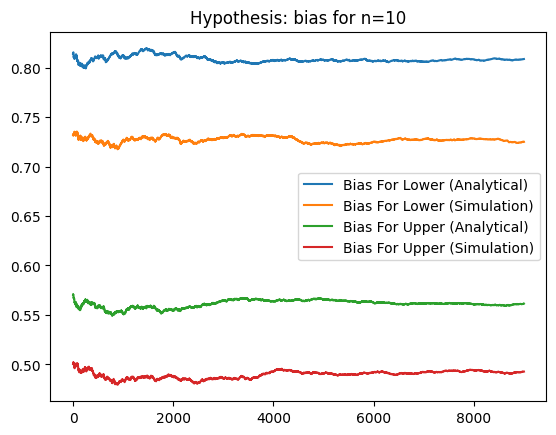

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta0/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta0/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-25-275779955501>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()


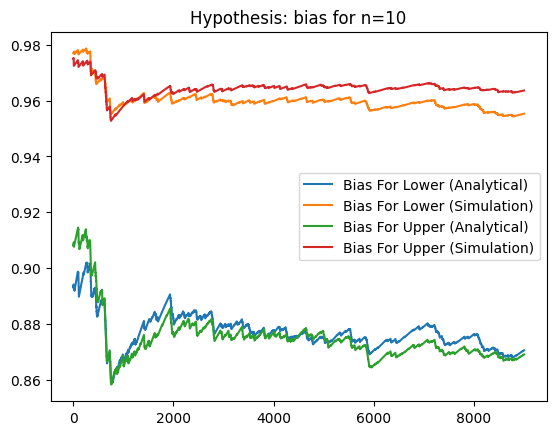

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma0**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta0/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta0/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



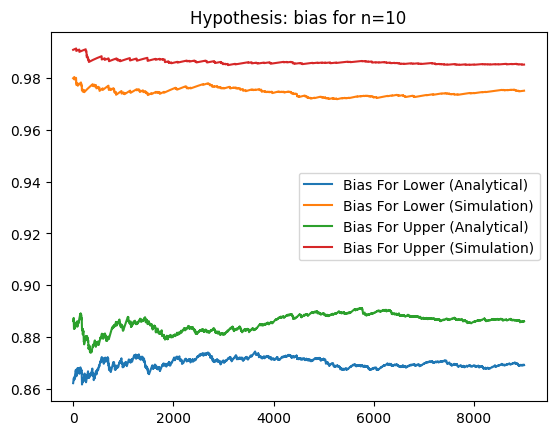

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-29-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


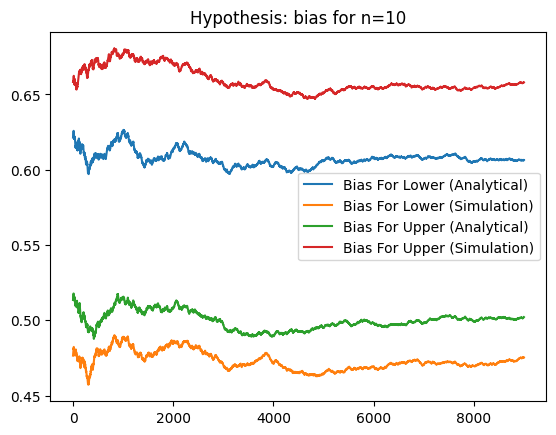

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma0**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-35-275779955501>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


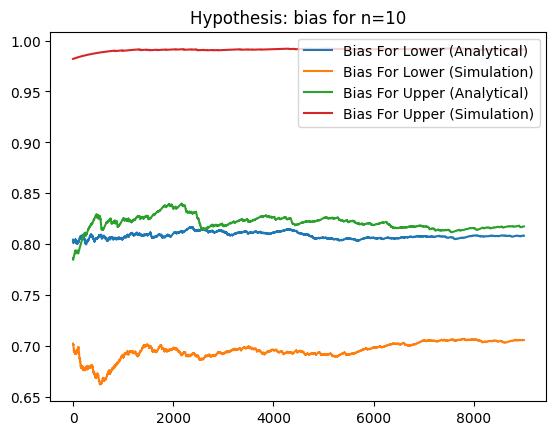

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 8  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 1036.83 seconds


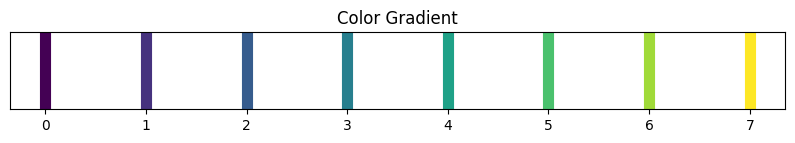

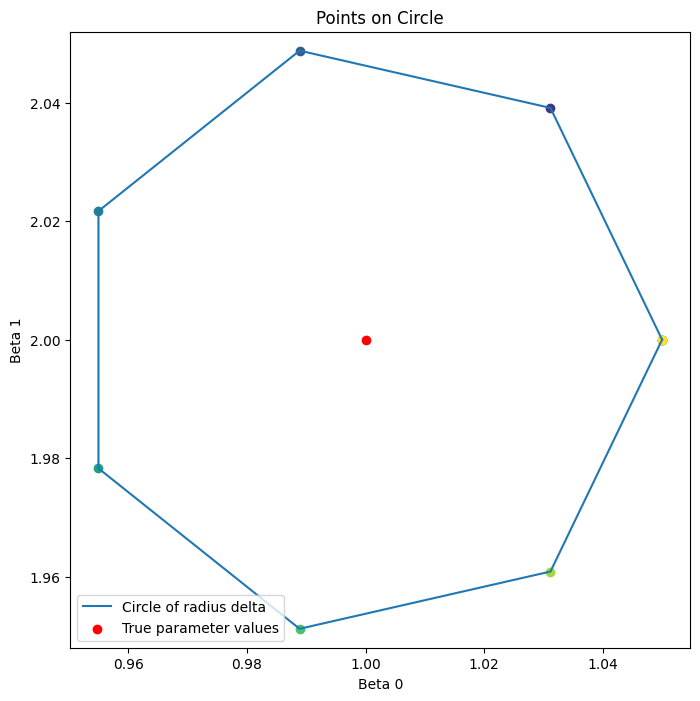

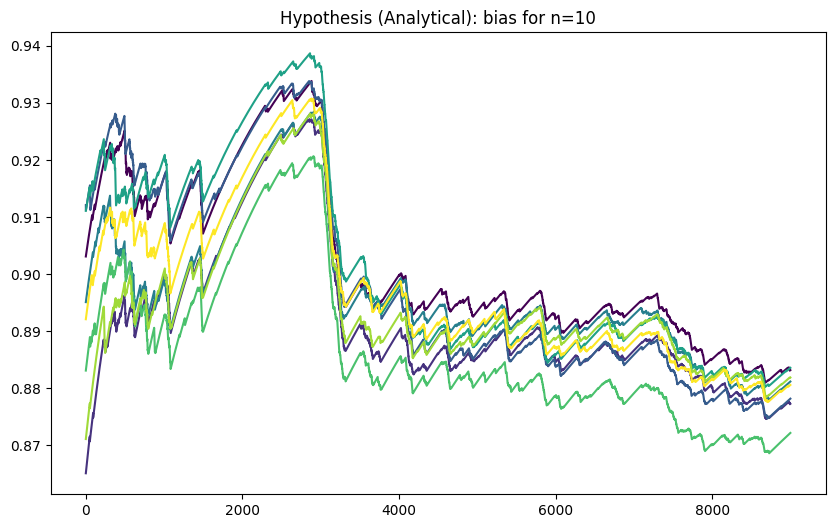

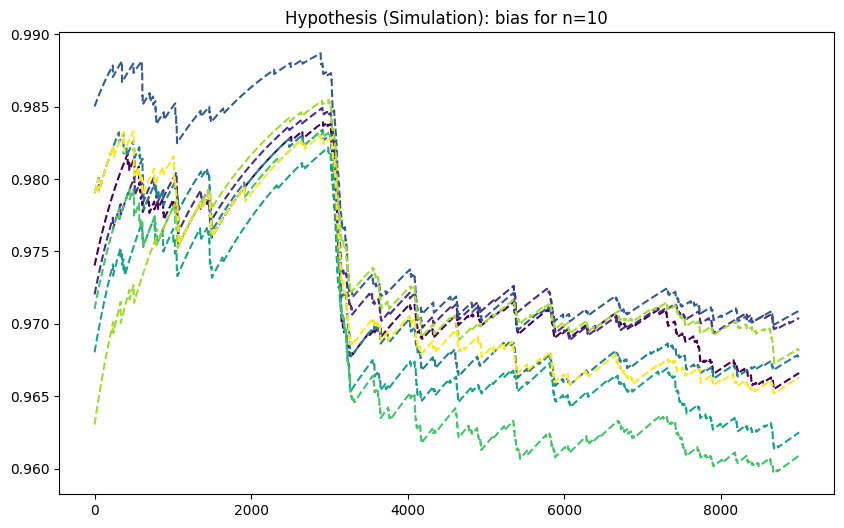

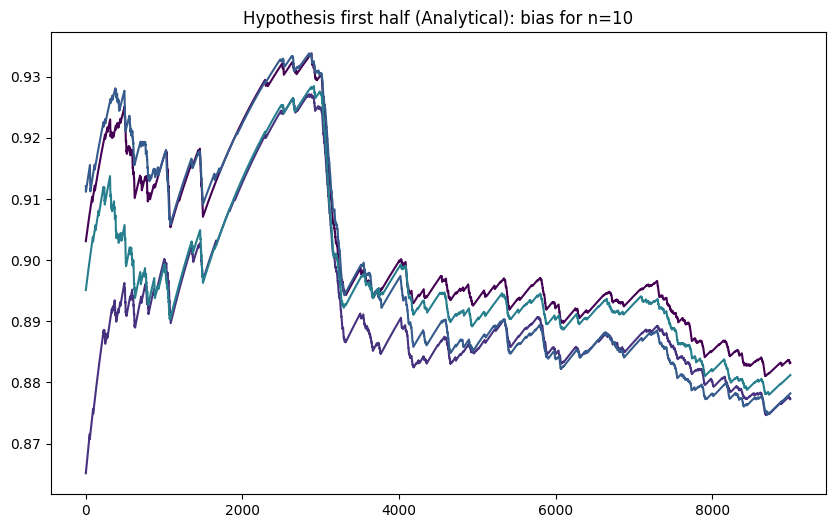

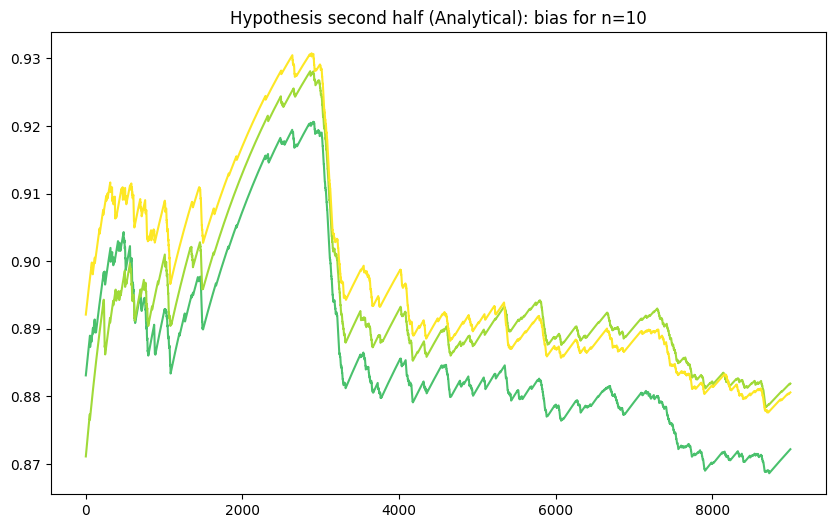

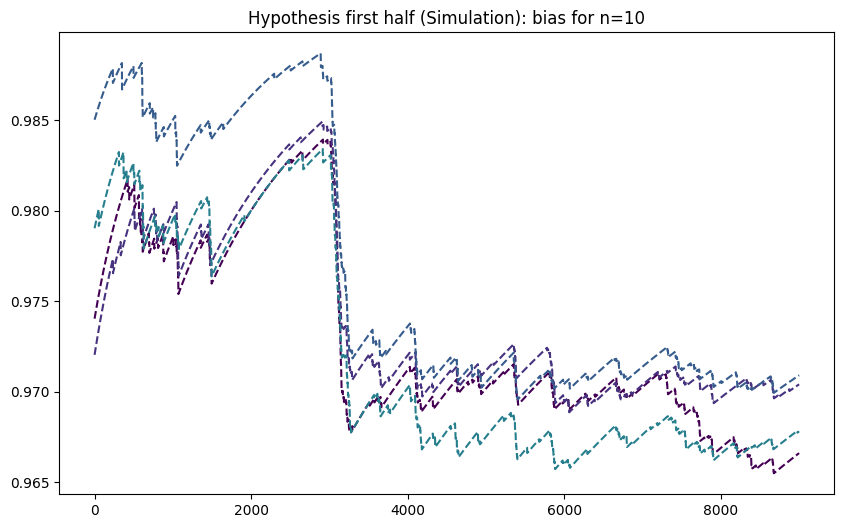

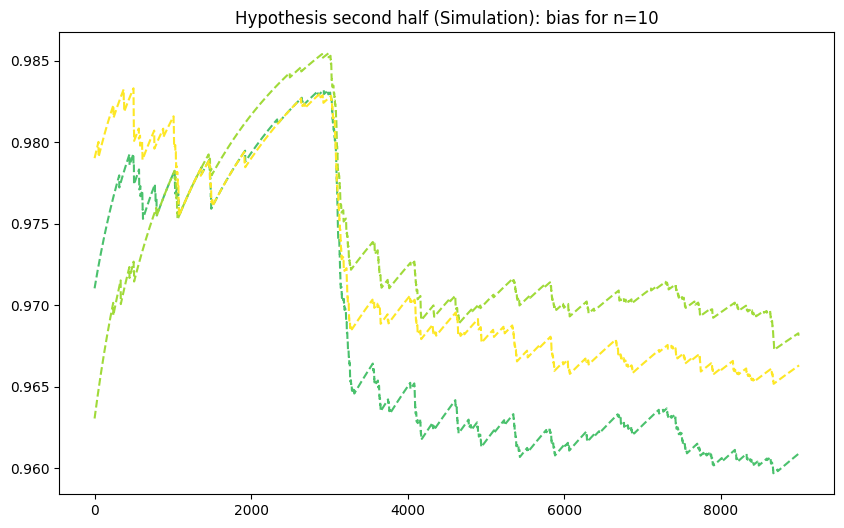

In [ ]:
# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])


plt.title("Hypothesis second half (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis first half (Simulation): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points//2 + 1, num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis second half (Simulation): bias for n={}".format(n))
plt.show()

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Graphs

In [14]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
deltas = [0.05, 0.15, 0.25, 0.5]
sigma0 = 1

biasfortotal = []
biasformltotal = []

for delta in deltas:
    # Generate points on the circle
    num_points = 6  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)


Cell execution time: 787.86 seconds


Cell execution time: 850.13 seconds


Cell execution time: 835.45 seconds


<ipython-input-14-0407409e4916>:84: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


Cell execution time: 564.03 seconds


<ipython-input-14-0407409e4916>:84: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


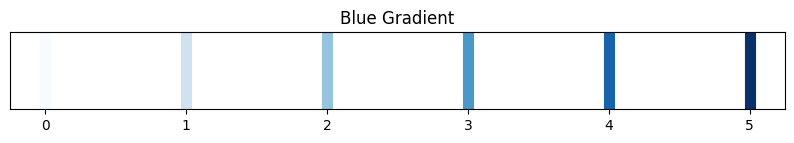

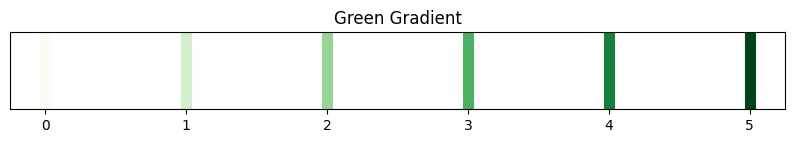

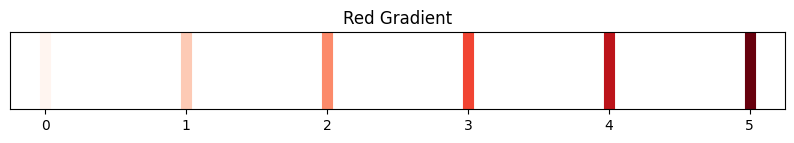

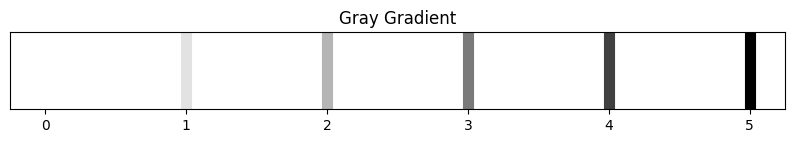

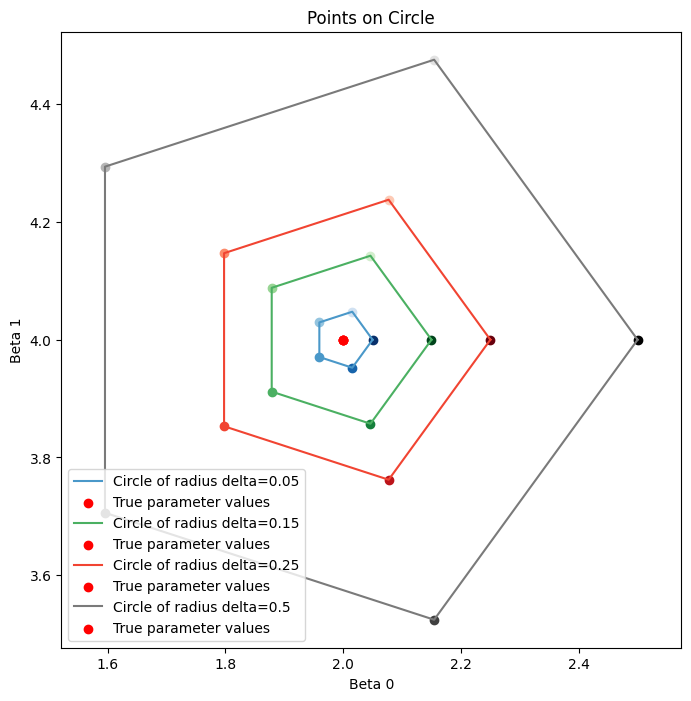

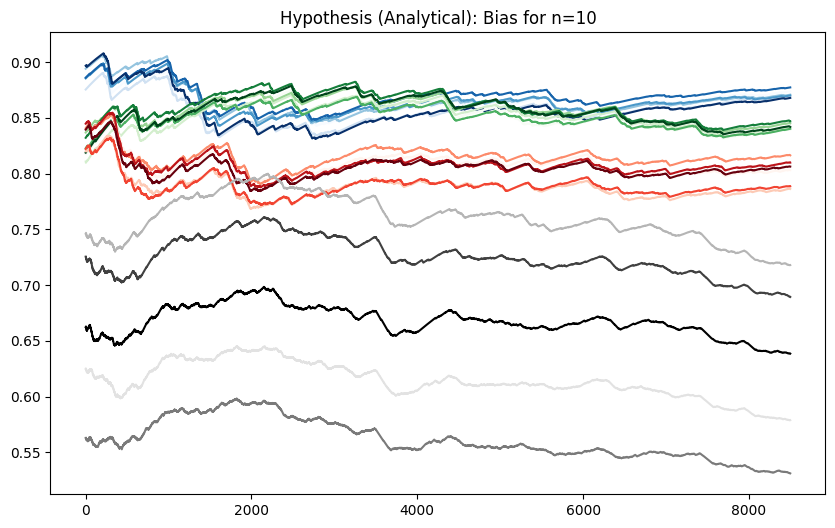

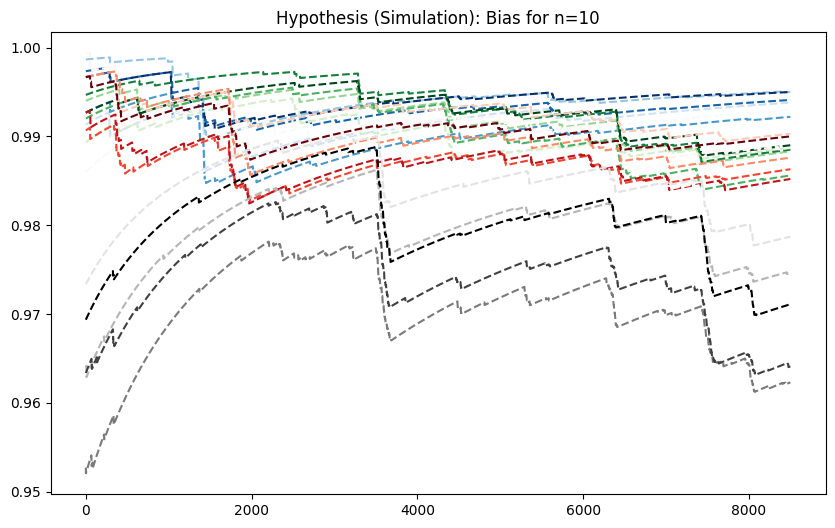

In [15]:
# Generate colors from colormaps
colors_blue = cm.Blues(np.linspace(0, 1, num_points))
colors_green = cm.Greens(np.linspace(0, 1, num_points))
colors_red = cm.Reds(np.linspace(0, 1, num_points))
colors_greys = cm.Greys(np.linspace(0, 1, num_points))

colors = [colors_blue, colors_green, colors_red, colors_greys]

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_blue):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Blue Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_green):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Green Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_red):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Red Gradient")
plt.yticks([])
plt.show()

plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors_greys):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Gray Gradient")
plt.yticks([])
plt.show()

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}', color=colors[i][num_points//2])

    # Plot
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()
burn=1500

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for idx in range(num_points):
        plt.plot(biasfortotal[i][idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[i][idx])

plt.title("Hypothesis (Analytical): Bias for n={}".format(n))
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for idx in range(num_points):
        plt.plot(biasformltotal[i][idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[i][idx])


plt.title("Hypothesis (Simulation): Bias for n={}".format(n))
plt.show()



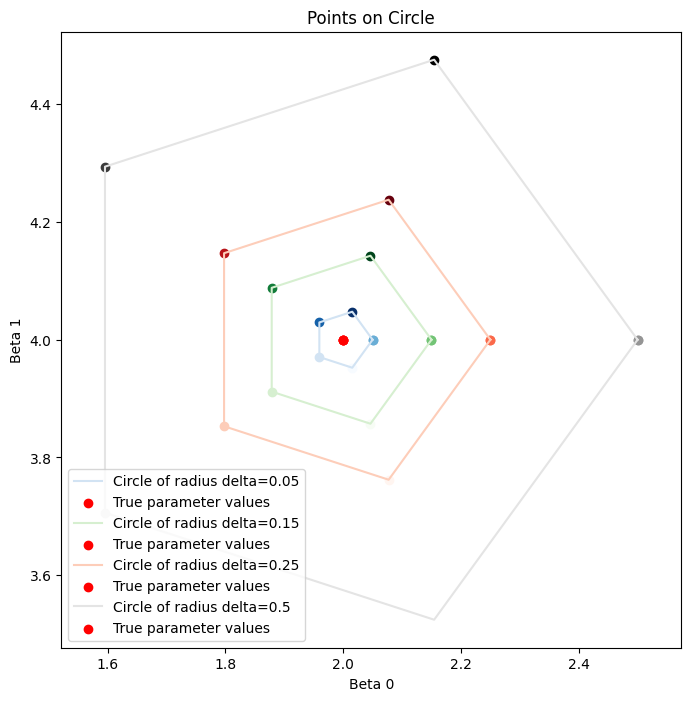

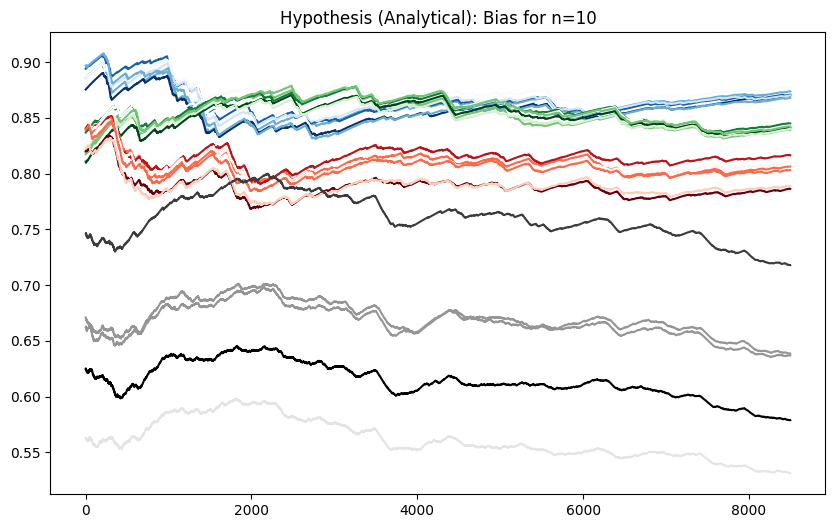

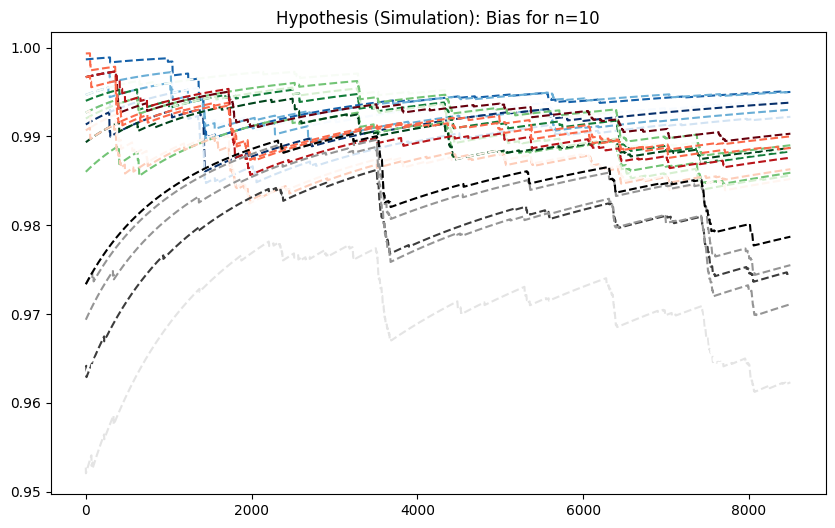

In [16]:
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + deltas[0] * np.cos(theta)
y = beta0[1] + deltas[0] * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + deltas[0] * np.cos(theta), beta0[1] + deltas[0] * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Blues(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Reds(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_blue, colors_green, colors_red, colors_greys]


# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}', color=colors[i][num_points//2])

    # Plot
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

burn=1500

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for idx in range(num_points):
        plt.plot(biasfortotal[i][idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[i][idx])

plt.title("Hypothesis (Analytical): Bias for n={}".format(n))
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    for idx in range(num_points):
        plt.plot(biasformltotal[i][idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[i][idx])


plt.title("Hypothesis (Simulation): Bias for n={}".format(n))
plt.show()



In [3]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 5  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

num_points = len(circle_points)

# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu =X@beta
    # Prior for beta at each point
    prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Likelihood
        mu_l = np.dot(X, betal)
        yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma**2) * np.eye(n), shape=n)

        #Lower
        mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=n), yl_).sum())


    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")



Cell execution time: 1751.10 seconds


<ipython-input-6-39d490fe64fc>:16: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


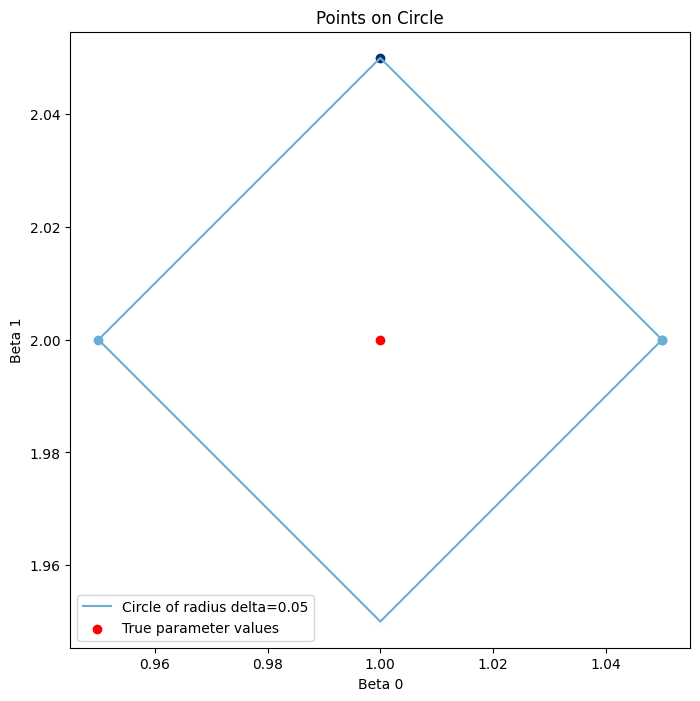

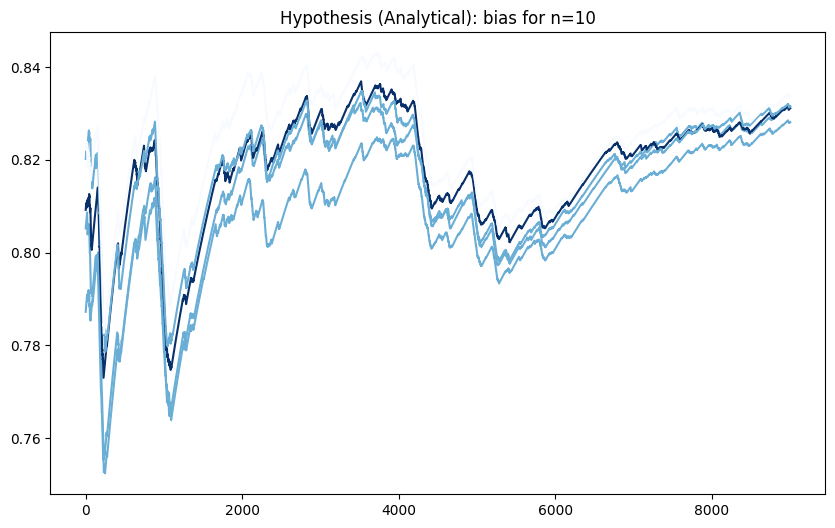

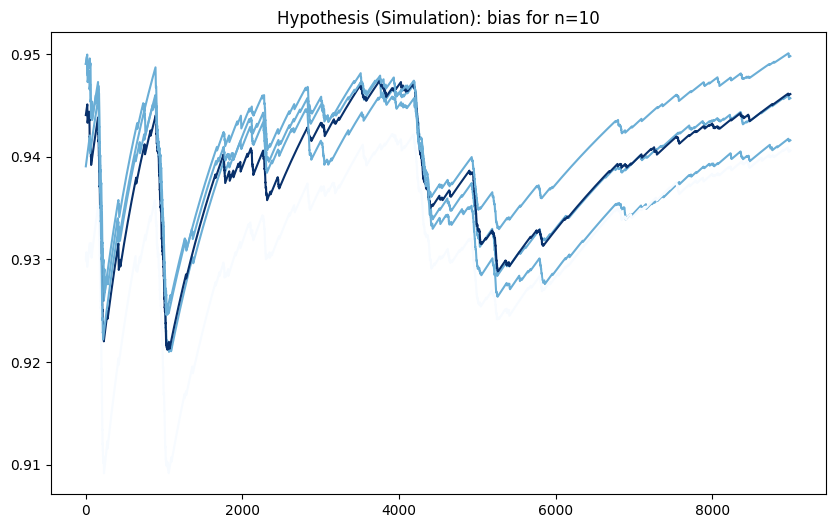

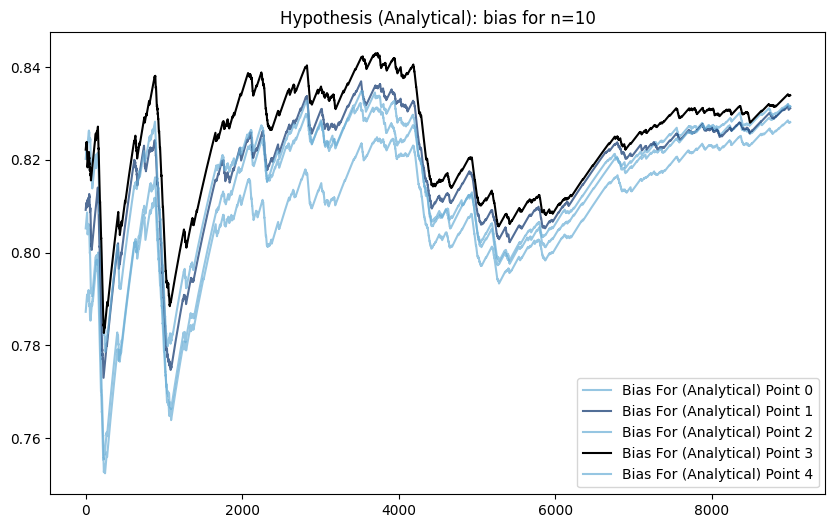

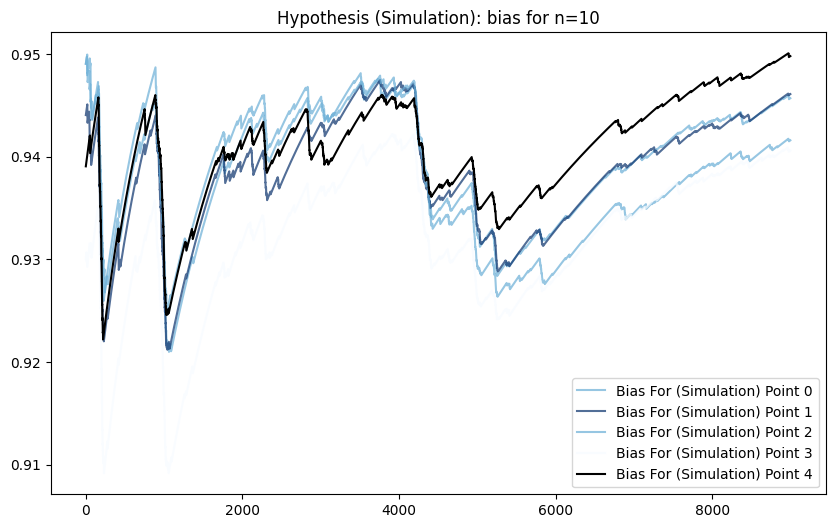

In [6]:
# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):

    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'yl_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Blues(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Reds(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_blue, colors_green, colors_red, colors_greys]


# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate([delta]):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}', color=colors[i][num_points//2])

    # Plot
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

colors  =colors[0]
# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

# Find the chain with the maximum final value
final_values_analytical = [chain[-1] for chain in bias_for]
max_final_idx_analytical = np.argmax(final_values_analytical)

final_values_simulation = [chain[-1] for chain in bias_for_ml]
max_final_idx_simulation = np.argmax(final_values_simulation)

# Plot for Analytical
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    if idx == max_final_idx_analytical:
        plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color='black')
    else:
        plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx], alpha=0.7)

plt.title(f"Hypothesis (Analytical): bias for n={n}")
plt.legend()
plt.show()

# Plot for Simulation
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    if idx == max_final_idx_simulation:
        plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color='black')
    else:
        plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colors[idx], alpha=0.7)

plt.title(f"Hypothesis (Simulation): bias for n={n}")
plt.legend()
plt.show()

In [25]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
deltas = [0.05, 0.25, 0.5, 1]
sigma0 = 1

biasfortotal = []
biasformltotal = []

for delta in deltas:
    # Generate points on the circle
    num_points = 5  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0) * np.eye(n), shape=n), yl_).sum())


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)


Cell execution time: 1289.08 seconds


Cell execution time: 398.38 seconds


Cell execution time: 396.60 seconds


Cell execution time: 386.85 seconds


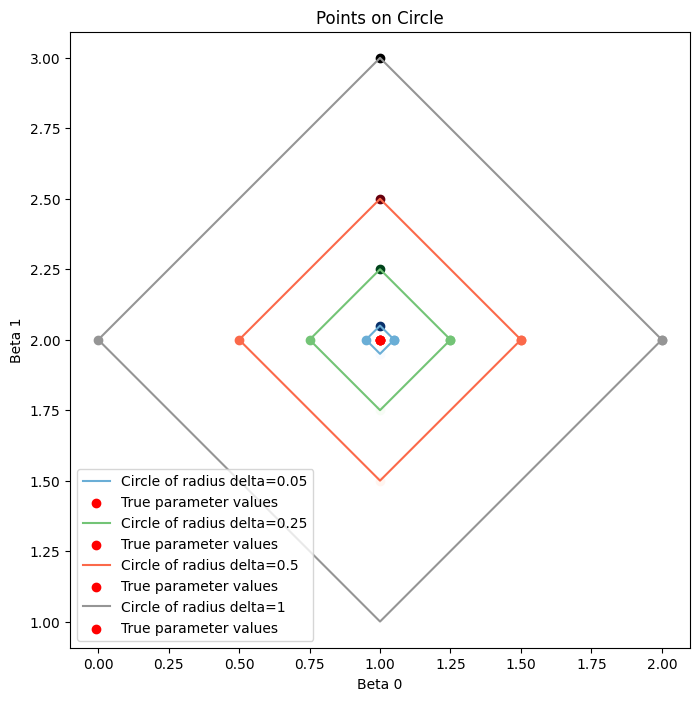

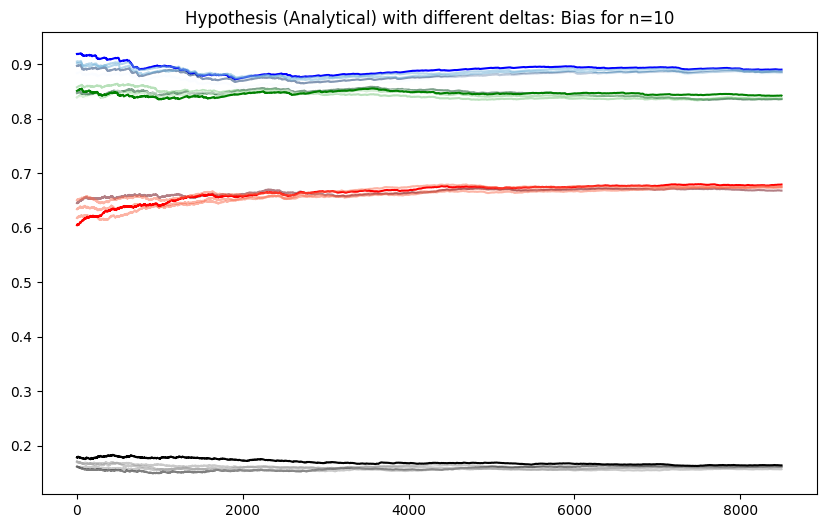

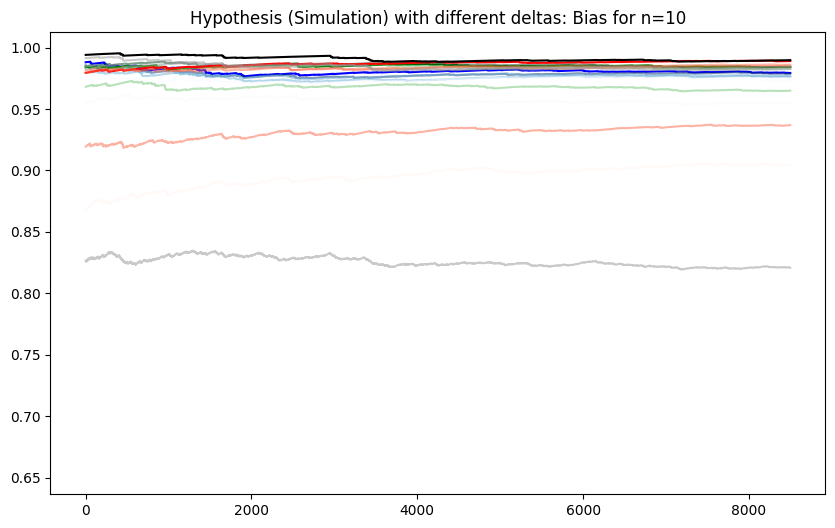

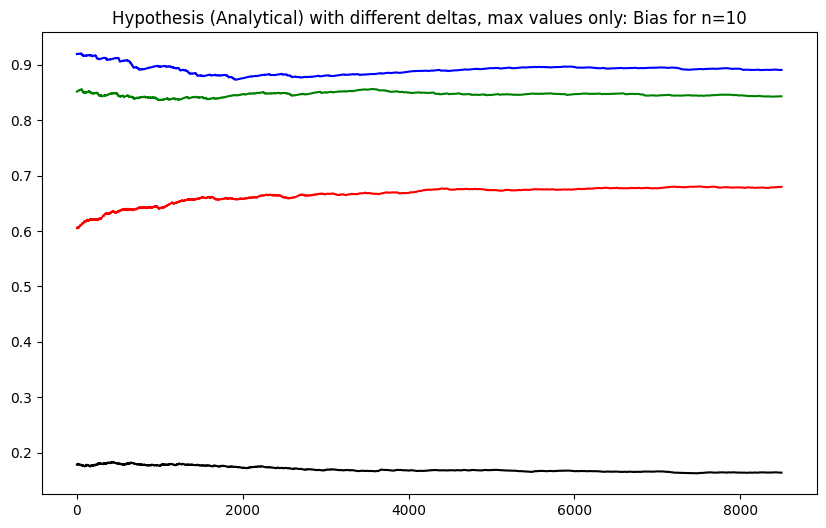

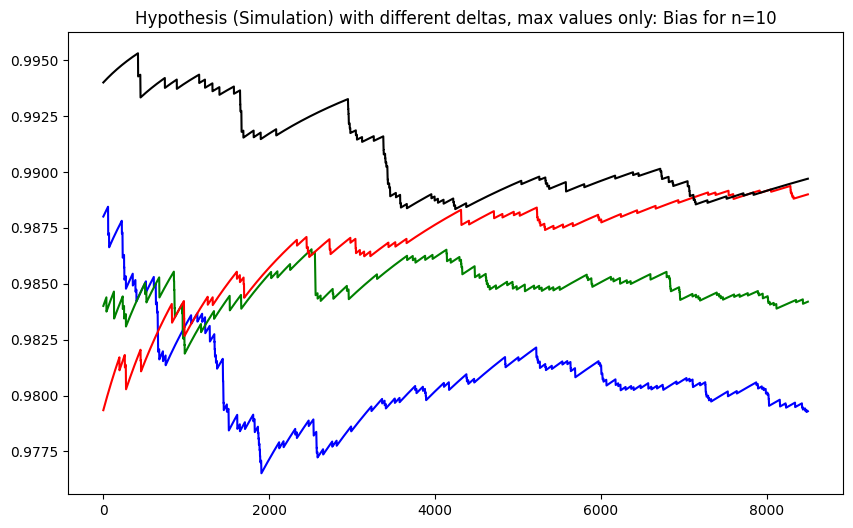

In [26]:
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + deltas[0] * np.cos(theta)
y = beta0[1] + deltas[0] * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + deltas[0] * np.cos(theta), beta0[1] + deltas[0] * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Blues(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Reds(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_blue, colors_green, colors_red, colors_greys]
colormid  =["blue", "green", "red", "black"]

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}', color=colors[i][num_points//2])

    # Plot
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

burn=1500

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):


        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colormid[i])
        else:
            plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[i][idx], alpha=0.5)


plt.title("Hypothesis (Analytical) with different deltas: Bias for n={}".format(n))
plt.show()



# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_simulation:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])
        else:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colors[i][idx], alpha=0.5)

plt.title("Hypothesis (Simulation) with different deltas: Bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colormid[i])



plt.title("Hypothesis (Analytical) with different deltas, max values only: Bias for n={}".format(n))
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_simulation:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])


plt.title("Hypothesis (Simulation) with different deltas, max values only: Bias for n={}".format(n))
plt.show()

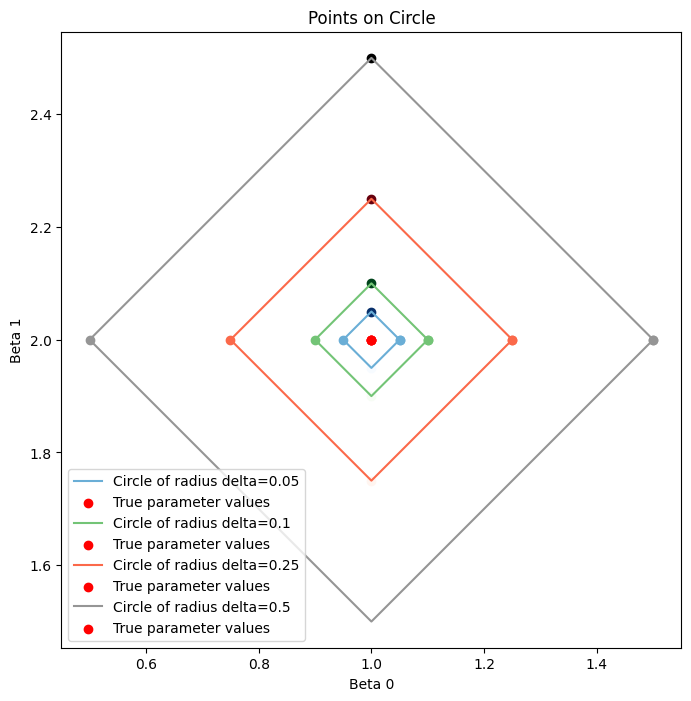

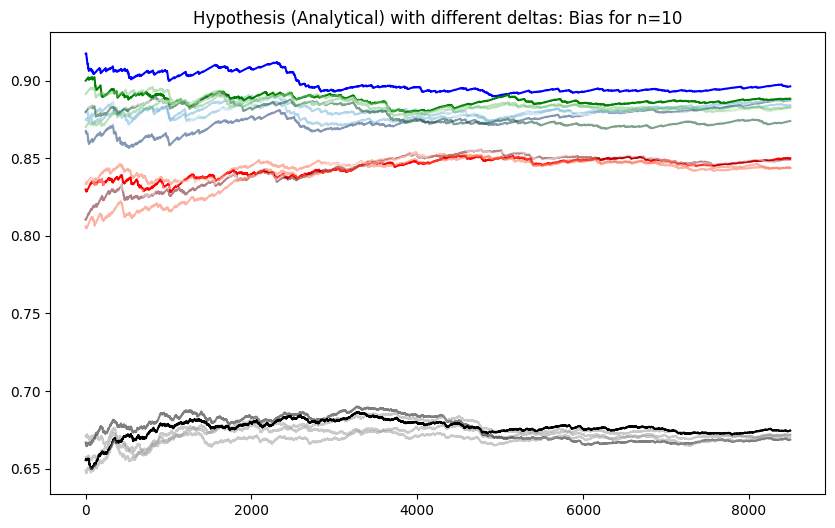

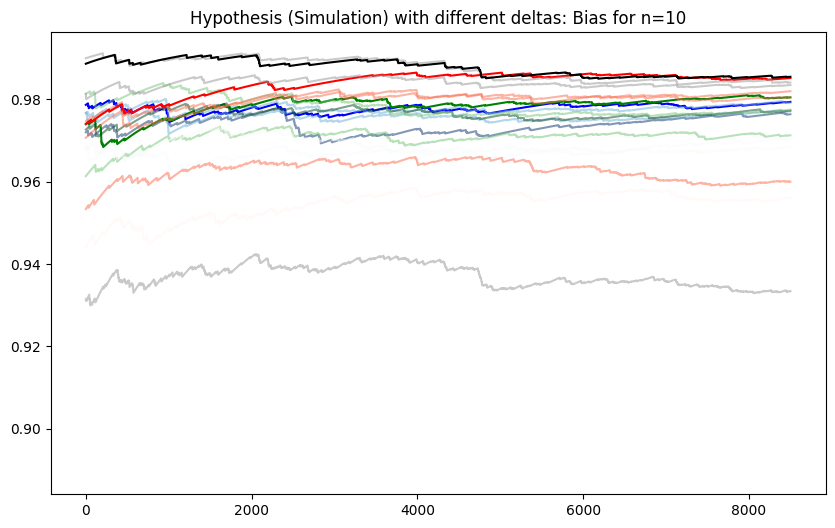

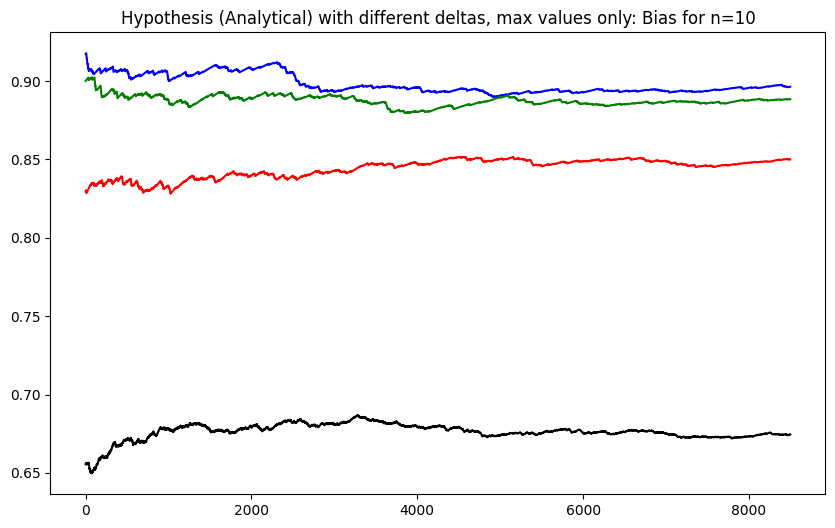

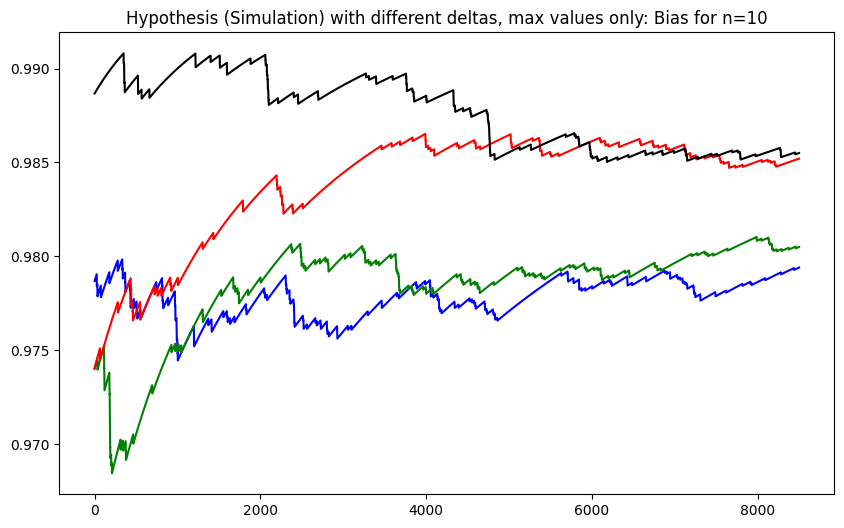

In [24]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
deltas = [0.05, 0.25, 0.5, 1]
sigma0 = 1

biasfortotal = []
biasformltotal = []

for delta in deltas:
    # Generate points on the circle
    num_points = 5  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0) * np.eye(n), shape=n), yl_).sum())


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)
